# Modelling and Evaluation

## Create a cross validation to find the best model for this task

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [30]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 5060 Ti


## Load the dataset

In [31]:
# Load dataset
data_path = "../datasets/preprocessed/final_df.csv"
df = pd.read_csv(data_path)
print("Dataset loaded with shape:", df.shape)
# Display first few rows of the dataset
df.head()

Dataset loaded with shape: (49181, 42)


,battery_id,cycle_index,protocol_id,discharge_capacity_ah_max,discharge_capacity_ah_mean,discharge_capacity_ah_min,charge_capacity_ah_max,charge_capacity_ah_mean,charge_capacity_ah_min,voltage_v_max,...,rolling_mean_soh_percent,rolling_std_discharge_capacity_ah_max,rolling_std_charge_capacity_ah_max,rolling_std_voltage_v_max,rolling_std_current_a_mean,rolling_std_discharge_energy_wh_max,rolling_std_charge_energy_wh_max,rolling_std_aux_temperature_1_c_mean,rolling_std_current_a_abs_mean,rolling_std_soh_percent
0,1,1,1,2.421769,0.849490,3.200319e-05,2.394174,2.115371,0.003330,4.200036,...,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,1,2.400751,0.442225,2.473989e-10,2.416324,1.819254,0.003330,4.200032,...,99.566061,0.014862,0.015662,0.000003,0.003854,0.228743,0.055605,0.524013,0.435901,0.613682
2,1,3,1,2.399412,0.442961,2.987066e-05,2.396731,1.805943,0.003330,4.200024,...,99.402985,0.012539,0.012118,0.000006,0.002735,0.187687,0.043485,0.444561,0.355911,0.517769
3,1,4,1,2.397874,0.443705,3.193769e-05,2.394747,1.803746,0.003329,4.200034,...,99.305570,0.011273,0.010610,0.000005,0.002262,0.163473,0.038482,0.387616,0.308554,0.465491
4,1,5,1,2.397038,0.443911,3.313753e-05,2.393583,1.802770,0.003329,4.200028,...,99.240217,0.010384,0.009694,0.000005,0.001984,0.146851,0.035502,0.347763,0.276177,0.428797


In [32]:
# Show updated columns
df.columns

Index(['battery_id', 'cycle_index', 'protocol_id', 'discharge_capacity_ah_max',
       'discharge_capacity_ah_mean', 'discharge_capacity_ah_min',
       'charge_capacity_ah_max', 'charge_capacity_ah_mean',
       'charge_capacity_ah_min', 'voltage_v_max', 'voltage_v_mean',
       'voltage_v_min', 'voltage_v_std', 'current_a_mean', 'current_a_std',
       'discharge_energy_wh_max', 'charge_energy_wh_max',
       'aux_temperature_1_c_mean', 'aux_temperature_1_c_max',
       'aux_temperature_1_c_min', 'aux_temperature_1_c_std',
       'current_a_abs_mean', 'soh_percent', 'rul',
       'rolling_mean_discharge_capacity_ah_max',
       'rolling_mean_charge_capacity_ah_max', 'rolling_mean_voltage_v_max',
       'rolling_mean_current_a_mean', 'rolling_mean_discharge_energy_wh_max',
       'rolling_mean_charge_energy_wh_max',
       'rolling_mean_aux_temperature_1_c_mean',
       'rolling_mean_current_a_abs_mean', 'rolling_mean_soh_percent',
       'rolling_std_discharge_capacity_ah_max',
     

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49181 entries, 0 to 49180
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   battery_id                              49181 non-null  int64  
 1   cycle_index                             49181 non-null  int64  
 2   protocol_id                             49181 non-null  int64  
 3   discharge_capacity_ah_max               49181 non-null  float64
 4   discharge_capacity_ah_mean              49181 non-null  float64
 5   discharge_capacity_ah_min               49181 non-null  float64
 6   charge_capacity_ah_max                  49181 non-null  float64
 7   charge_capacity_ah_mean                 49181 non-null  float64
 8   charge_capacity_ah_min                  49181 non-null  float64
 9   voltage_v_max                           49181 non-null  float64
 10  voltage_v_mean                          49181 non-null  fl

In [34]:
# Convert protocol_id to categorical
categorical_features = ['protocol_id']
for col in categorical_features:
    df[col] = df[col].astype('category')
# Verify conversion
df.dtypes

battery_id                                   int64
cycle_index                                  int64
protocol_id                               category
discharge_capacity_ah_max                  float64
discharge_capacity_ah_mean                 float64
discharge_capacity_ah_min                  float64
charge_capacity_ah_max                     float64
charge_capacity_ah_mean                    float64
charge_capacity_ah_min                     float64
voltage_v_max                              float64
voltage_v_mean                             float64
voltage_v_min                              float64
voltage_v_std                              float64
current_a_mean                             float64
current_a_std                              float64
discharge_energy_wh_max                    float64
charge_energy_wh_max                       float64
aux_temperature_1_c_mean                   float64
aux_temperature_1_c_max                    float64
aux_temperature_1_c_min        

In [35]:
# Drop all rows with negative RUL
df = df[df['rul'] >= 0].reset_index(drop=True)
print("Dataset shape after removing negative RUL:", df.shape)
# Verify no negative RUL values remain
print("Negative RUL values remaining:", (df['rul'] < 0).sum())

Dataset shape after removing negative RUL: (38688, 42)
Negative RUL values remaining: 0


In [36]:
# Drop rows with battery_id 61 and 62
df = df[~df['battery_id'].isin([61, 62])].reset_index(drop=True)
print("Dataset shape after removing battery_id 61 and 62:", df.shape)

Dataset shape after removing battery_id 61 and 62: (37926, 42)


## Split Train and Test data

In [37]:
# Using battery id to split data into train and test sets
battery_ids = df['battery_id'].unique()
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)
train_df = df[df['battery_id'].isin(train_ids)]
test_df = df[df['battery_id'].isin(test_ids)]
X_train = train_df.drop(columns=['rul', 'battery_id', 'cycle_index'])
y_train = train_df['rul']
X_test = test_df.drop(columns=['rul', 'battery_id', 'cycle_index'])
y_test = test_df['rul']
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (31950, 39) (31950,)
Test set shape: (5976, 39) (5976,)


In [38]:
# Create a pipeline for preprocessing
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object','category']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
# Fit and transform the training data, transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("Processed train set shape:", X_train_processed.shape)
print("Processed test set shape:", X_test_processed.shape)

Processed train set shape: (31950, 54)
Processed test set shape: (5976, 54)


## Train the model

In [39]:
# Task 1: Scikit-learn Model Comparison
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBRegressor': xgb.XGBRegressor(random_state=42),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# Store results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Train the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Store results
    results.append({
        'Model': model_name,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })
    
    print(f"{model_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

# Create and display results DataFrame
results_df = pd.DataFrame(results)
print("\n=== Model Comparison Results ===")
print(results_df.to_string(index=False))

Training LinearRegression...
LinearRegression - R2: 0.7738, RMSE: 116.5201, MAE: 75.0124, MAPE: 1258116213875499.2500
Training SVR...
SVR - R2: 0.7994, RMSE: 109.7382, MAE: 64.0685, MAPE: 797730001388222.2500
Training RandomForestRegressor...
SVR - R2: 0.7994, RMSE: 109.7382, MAE: 64.0685, MAPE: 797730001388222.2500
Training RandomForestRegressor...
RandomForestRegressor - R2: 0.8083, RMSE: 107.2878, MAE: 51.4465, MAPE: 303714137521182.5625
Training XGBRegressor...
XGBRegressor - R2: 0.8243, RMSE: 102.6899, MAE: 49.2487, MAPE: 361558064496640.0000
Training MLPRegressor...
RandomForestRegressor - R2: 0.8083, RMSE: 107.2878, MAE: 51.4465, MAPE: 303714137521182.5625
Training XGBRegressor...
XGBRegressor - R2: 0.8243, RMSE: 102.6899, MAE: 49.2487, MAPE: 361558064496640.0000
Training MLPRegressor...
MLPRegressor - R2: 0.7992, RMSE: 109.7827, MAE: 58.3585, MAPE: 578125014672910.1250

=== Model Comparison Results ===
                Model       R2       RMSE       MAE         MAPE
     Linear

In [40]:
# Task 2: Feature Ablation Study (Using Random Forest) - IMPROVED
print("\n=== Feature Ablation Study ===")

# Define feature groups with error handling
available_columns = set(X_train.columns)

# Check which rolling features are available
rolling_features = [col for col in X_train.columns if 'rolling_' in col]
print(f"Found {len(rolling_features)} rolling features")

feature_groups = {
    'Capacity_Only': ['soh_percent', 'discharge_capacity_ah_max'],
    'Capacity_Voltage': ['soh_percent', 'discharge_capacity_ah_max', 'voltage_v_std', 'voltage_v_mean'],
    'Capacity_Temp': ['soh_percent', 'discharge_capacity_ah_max', 'aux_temperature_1_c_mean', 'aux_temperature_1_c_std'],
    'Capacity_Rolling': ['soh_percent', 'discharge_capacity_ah_max'] + rolling_features,
    'All_Features': list(X_train.columns)
}

# Store ablation results and models
ablation_results = []
trained_models = {}

# Iterate through each feature group
for group_name, features in feature_groups.items():
    # Filter out features that don't exist
    valid_features = [f for f in features if f in available_columns]
    
    if len(valid_features) == 0:
        print(f"\nSkipping {group_name}: No valid features found")
        continue
    
    missing_features = set(features) - set(valid_features)
    if missing_features:
        print(f"\nWarning: {group_name} missing features: {missing_features}")
    
    print(f"\nEvaluating feature group: {group_name} ({len(valid_features)} features)")
    
    # Create subset of features
    X_train_subset = X_train[valid_features]
    X_test_subset = X_test[valid_features]
    
    # Identify numeric and categorical features in this subset
    numeric_features_subset = X_train_subset.select_dtypes(include=['int64', 'float64']).columns
    categorical_features_subset = X_train_subset.select_dtypes(include=['object', 'category']).columns
    
    # Create new preprocessor for this subset
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    transformers = []
    if len(numeric_features_subset) > 0:
        transformers.append(('num', numeric_transformer, numeric_features_subset))
    if len(categorical_features_subset) > 0:
        transformers.append(('cat', categorical_transformer, categorical_features_subset))
    
    preprocessor_subset = ColumnTransformer(transformers=transformers)
    
    # Fit and transform the data
    X_train_processed_subset = preprocessor_subset.fit_transform(X_train_subset)
    X_test_processed_subset = preprocessor_subset.transform(X_test_subset)
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_processed_subset, y_train)
    
    # Store the model
    trained_models[group_name] = rf_model
    
    # Make predictions
    y_pred = rf_model.predict(X_test_processed_subset)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    ablation_results.append({
        'Feature_Group': group_name,
        'Num_Features': len(valid_features),
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae
    })
    
    print(f"{group_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Create and display ablation results DataFrame
ablation_df = pd.DataFrame(ablation_results)

# Sort by R2 score (descending)
ablation_df = ablation_df.sort_values('R2', ascending=False).reset_index(drop=True)

# Add improvement over baseline (Capacity_Only)
if 'Capacity_Only' in ablation_df['Feature_Group'].values:
    baseline_r2 = ablation_df[ablation_df['Feature_Group'] == 'Capacity_Only']['R2'].values[0]
    baseline_rmse = ablation_df[ablation_df['Feature_Group'] == 'Capacity_Only']['RMSE'].values[0]
    ablation_df['R2_Improvement_%'] = ((ablation_df['R2'] - baseline_r2) / abs(baseline_r2)) * 100
    ablation_df['RMSE_Reduction_%'] = ((baseline_rmse - ablation_df['RMSE']) / baseline_rmse) * 100

print("\n=== Feature Ablation Results (Sorted by R2) ===")
print(ablation_df.to_string(index=False))

# Identify best performing feature group
best_group = ablation_df.iloc[0]['Feature_Group']
print(f"\n✓ Best performing feature group: {best_group}")


=== Feature Ablation Study ===
Found 18 rolling features

Evaluating feature group: Capacity_Only (2 features)
Capacity_Only - R2: -0.1412, RMSE: 261.7402, MAE: 195.3272

Evaluating feature group: Capacity_Voltage (4 features)
Capacity_Only - R2: -0.1412, RMSE: 261.7402, MAE: 195.3272

Evaluating feature group: Capacity_Voltage (4 features)
Capacity_Voltage - R2: 0.7182, RMSE: 130.0780, MAE: 68.5971

Evaluating feature group: Capacity_Temp (4 features)
Capacity_Voltage - R2: 0.7182, RMSE: 130.0780, MAE: 68.5971

Evaluating feature group: Capacity_Temp (4 features)
Capacity_Temp - R2: 0.3919, RMSE: 191.0598, MAE: 127.8518

Evaluating feature group: Capacity_Rolling (20 features)
Capacity_Temp - R2: 0.3919, RMSE: 191.0598, MAE: 127.8518

Evaluating feature group: Capacity_Rolling (20 features)
Capacity_Rolling - R2: 0.7992, RMSE: 109.7892, MAE: 54.8166

Evaluating feature group: All_Features (39 features)
Capacity_Rolling - R2: 0.7992, RMSE: 109.7892, MAE: 54.8166

Evaluating feature gr

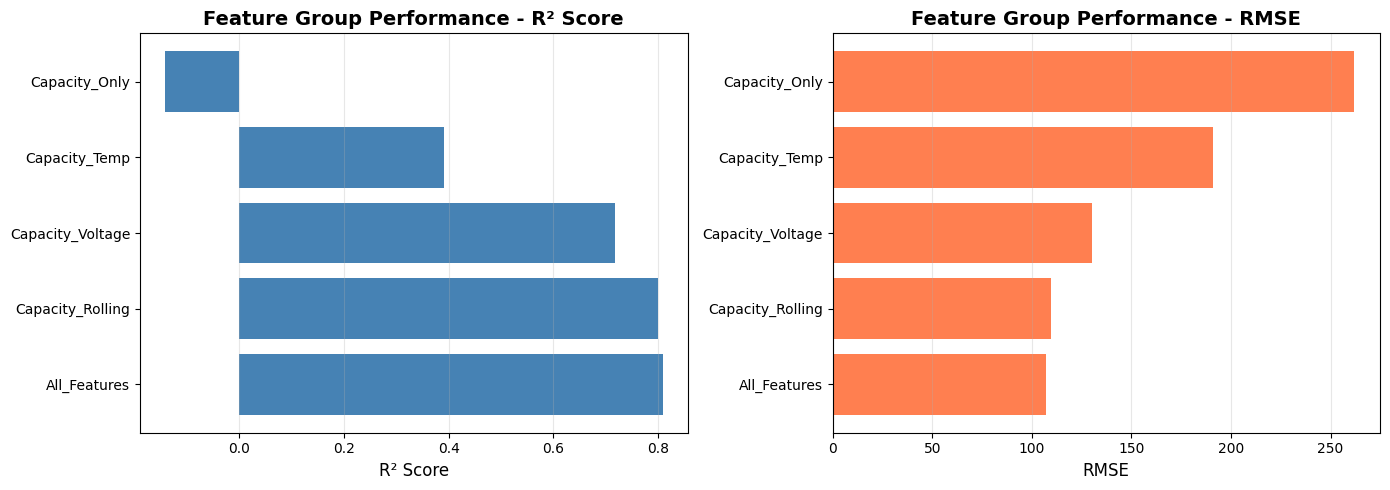


Best feature group 'All_Features' achieved R² = 0.8083


In [41]:
# Visualize Feature Ablation Results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot R2 scores
axes[0].barh(ablation_df['Feature_Group'], ablation_df['R2'], color='steelblue')
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('Feature Group Performance - R² Score', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Plot RMSE
axes[1].barh(ablation_df['Feature_Group'], ablation_df['RMSE'], color='coral')
axes[1].set_xlabel('RMSE', fontsize=12)
axes[1].set_title('Feature Group Performance - RMSE', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest feature group '{best_group}' achieved R² = {ablation_df.iloc[0]['R2']:.4f}")


=== Feature Importance for 'All_Features' Model ===
Total features after preprocessing: 54
Feature names extracted: 54


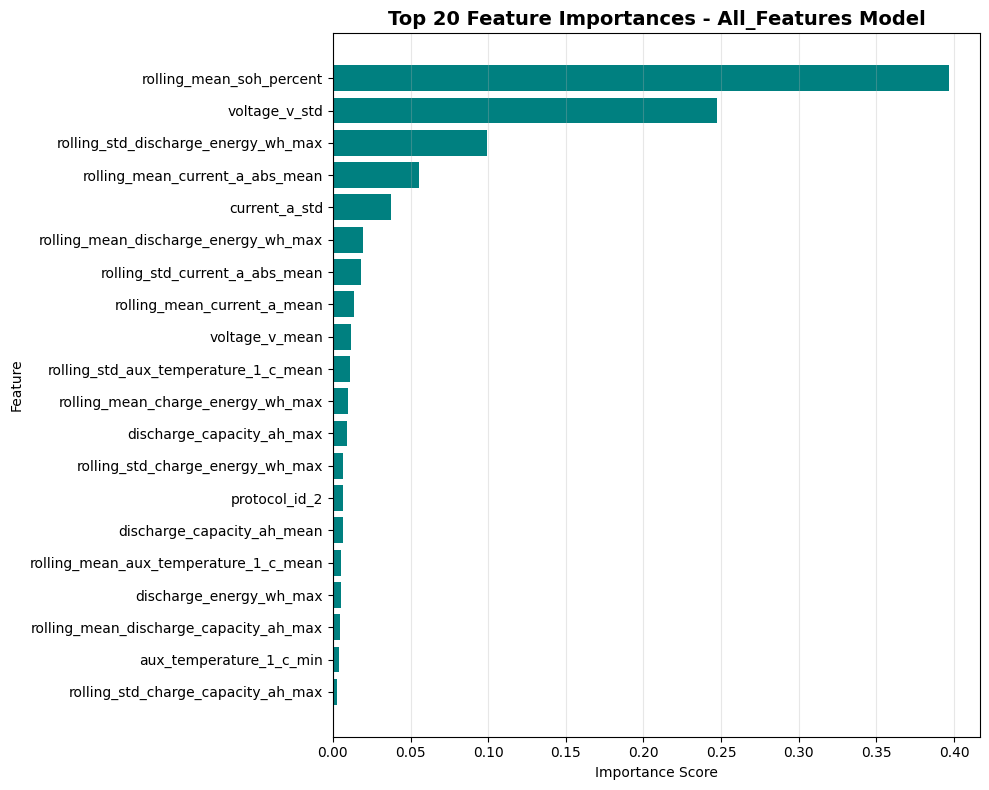


Top 10 features by importance:
1. rolling_mean_soh_percent: 0.3969
2. voltage_v_std: 0.2476
3. rolling_std_discharge_energy_wh_max: 0.0991
4. rolling_mean_current_a_abs_mean: 0.0555
5. current_a_std: 0.0373
6. rolling_mean_discharge_energy_wh_max: 0.0195
7. rolling_std_current_a_abs_mean: 0.0183
8. rolling_mean_current_a_mean: 0.0137
9. voltage_v_mean: 0.0117
10. rolling_std_aux_temperature_1_c_mean: 0.0112


In [42]:
# Feature Importance Analysis for Best Model
if best_group in trained_models:
    best_model = trained_models[best_group]
    
    # Get feature names after preprocessing
    feature_group_features = feature_groups[best_group]
    valid_features = [f for f in feature_group_features if f in available_columns]
    
    # Recreate the subset for this feature group
    X_train_subset = X_train[valid_features]
    
    # Identify numeric and categorical features in this subset
    numeric_features_subset = X_train_subset.select_dtypes(include=['int64', 'float64']).columns
    categorical_features_subset = X_train_subset.select_dtypes(include=['object', 'category']).columns
    
    # Create preprocessor to get feature names
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    transformers = []
    if len(numeric_features_subset) > 0:
        transformers.append(('num', numeric_transformer, numeric_features_subset))
    if len(categorical_features_subset) > 0:
        transformers.append(('cat', categorical_transformer, categorical_features_subset))
    
    preprocessor_subset = ColumnTransformer(transformers=transformers)
    preprocessor_subset.fit(X_train_subset)
    
    # Get feature names after preprocessing
    feature_names = []
    
    # Add numeric feature names
    if len(numeric_features_subset) > 0:
        feature_names.extend(numeric_features_subset.tolist())
    
    # Add categorical feature names (one-hot encoded)
    if len(categorical_features_subset) > 0:
        cat_encoder = preprocessor_subset.named_transformers_['cat'].named_steps['onehot']
        for i, cat_feature in enumerate(categorical_features_subset):
            cat_categories = cat_encoder.categories_[i]
            feature_names.extend([f"{cat_feature}_{cat}" for cat in cat_categories])
    
    # Get feature importance
    importances = best_model.feature_importances_
    
    print(f"\n=== Feature Importance for '{best_group}' Model ===")
    print(f"Total features after preprocessing: {len(importances)}")
    print(f"Feature names extracted: {len(feature_names)}")
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Ensure same length
        'Importance': importances
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    # Plot top features
    n_top = min(20, len(importance_df))
    top_features = importance_df.head(n_top)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(n_top), top_features['Importance'].values, color='teal')
    plt.yticks(range(n_top), top_features['Feature'].values)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title(f'Top {n_top} Feature Importances - {best_group} Model', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 10 features by importance:")
    for i, row in enumerate(importance_df.head(10).itertuples(), 1):
        print(f"{i}. {row.Feature}: {row.Importance:.4f}")
